# Comparison of kernel ridge regression and SVR

Both kernel ridge regression (KRR) and SVR learn a non-linear function by employing the kernel trick, i.e., they learn a linear function in the space induced by the respective kernel which corresponds to a non-linear function in the original space. They differ in the loss functions (ridge versus epsilon-insensitive loss). In contrast to SVR, fitting a KRR can be done in closed-form and is typically faster for medium-sized datasets. On the other hand, the learned model is non-sparse and thus slower than SVR at prediction-time.

This example illustrates both methods on an artificial dataset, which consists of a sinusoidal target function and strong noise added to every fifth datapoint.

## Generate sample data

In [1]:
import numpy as np

rng = np.random.RandomState(42)

X = 5 * rng.rand(10000, 1)
y = np.sin(X).ravel()

# Add noise to targets
y[::5] += 3 * (0.5 - rng.rand(X.shape[0] // 5))

# Define x axis for plotting of test data
X_plot = np.linspace(0, 5, 100000)[:, None]

## Construct the kernel-based regression models

In [2]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

train_size = 100

svr = GridSearchCV(
    SVR(kernel='rbf', gamma=0.1),
    param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                "gamma": np.logspace(-2, 2, 5)},
    )

kr = GridSearchCV(
    KernelRidge(kernel='rbf', gamma=0.1),
    param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                "gamma": np.logspace(-2, 2, 5)},
    )

## Compare training and inferencing times of SVR and Kernel Ridge Regression

In [3]:
import time

t0 = time.time()
svr.fit(X[:train_size], y[:train_size])
svr_fit = time.time() - t0
print(f"Best SVR parameters: {svr.best_params_} and R2 score: {svr.best_score_:0.3f}")
print("SVR complexity and bandwidth selected and model fitted in %.3f s"
      % svr_fit)

Best SVR parameters: {'C': 1.0, 'gamma': 0.1} and R2 score: 0.737
SVR complexity and bandwidth selected and model fitted in 0.772 s


In [4]:
t0 = time.time()
kr.fit(X[:train_size], y[:train_size])
kr_fit = time.time() - t0
print(f"Best Kernel Ridge parameters: {kr.best_params_} and R2 score: {kr.best_score_:0.3f}")
print("Kernel Ridge complexity and bandwidth selected and model fitted in %.3f s"
      % kr_fit)

Best Kernel Ridge parameters: {'alpha': 0.1, 'gamma': 0.1} and R2 score: 0.723
Kernel Ridge complexity and bandwidth selected and model fitted in 0.335 s


In [5]:
sv_ratio = svr.best_estimator_.support_.shape[0] / train_size
print(f"Support vector ratio: {sv_ratio:.3f}")

t0 = time.time()
y_svr = svr.predict(X_plot)
svr_predict = time.time() - t0
print(f"SVR prediction for {X_plot.shape[0]} points in {svr_predict:.3f} s")

Support vector ratio: 0.340
SVR prediction for 100000 points in 0.142 s


In [6]:
t0 = time.time()
y_kr = kr.predict(X_plot)
kr_predict = time.time() - t0
print("KRR prediction for %d inputs in %.3f s" % (X_plot.shape[0], kr_predict))

KRR prediction for 100000 inputs in 0.203 s


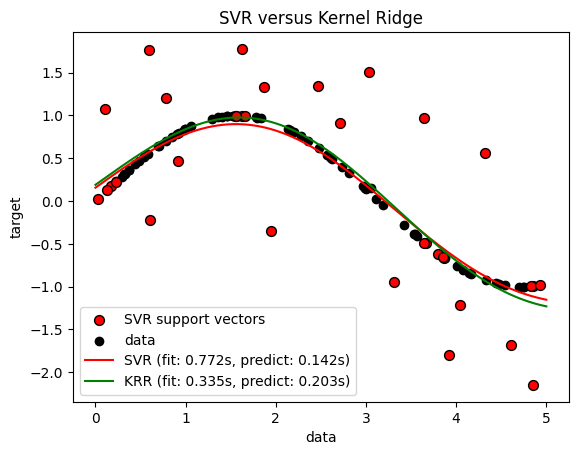

In [7]:
# Look at the results
import matplotlib.pyplot as plt

sv_ind = svr.best_estimator_.support_
plt.scatter(
    X[sv_ind], 
    y[sv_ind], 
    c='r', 
    s=50, label='SVR support vectors',
    zorder=2,
    edgecolors=(0, 0, 0),
    )
plt.scatter(
    X[:100], 
    y[:100], 
    c='k', label='data',
    zorder=1,
    edgecolors=(0, 0, 0),
    )
plt.plot(
    X_plot, 
    y_svr, 
    c='r', label='SVR (fit: %.3fs, predict: %.3fs)' % (svr_fit, svr_predict),
    )
plt.plot(
    X_plot, 
    y_kr, 
    c='g', label='KRR (fit: %.3fs, predict: %.3fs)' % (kr_fit, kr_predict),
    )
plt.xlabel('data')
plt.ylabel('target')
plt.title('SVR versus Kernel Ridge')
plt.legend()

The previous figure compares the learned model of KRR and SVR when both complexity/regularization and bandwidth of the RBF kernel are optimized using grid-search. The learned functions are very similar; however, fitting KRR is approximately 3-4 times faster than fitting SVR (both with grid-search).

Prediction of 100000 target values could be in theory approximately three times faster with SVR since it has learned a sparse model using only approximately 1/3 of the training datapoints as support vectors. However, in practice, this is not necessarily the case because of implementation details in the way the kernel function is computed for each model that can make the KRR model as fast or even faster despite computing more arithmetic operations.

## Visualize training and prediction time

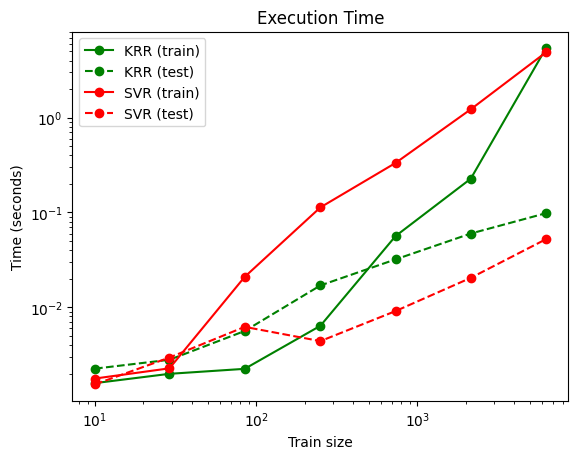

In [8]:
plt.figure()

sizes = np.logspace(1, 3.8, 7).astype(int)
for name, estimator in {
    "KRR": KernelRidge(kernel="rbf", alpha=0.01, gamma=10),
    "SVR": SVR(kernel="rbf", C=1e2, gamma=10),
}.items():
    train_time = []
    test_time = []
    for train_test_size in sizes:
        t0 = time.time()
        estimator.fit(X[:train_test_size], y[:train_test_size])
        train_time.append(time.time() - t0)

        t0 = time.time()
        estimator.predict(X_plot[:1000])
        test_time.append(time.time() - t0)

    plt.plot(
        sizes,
        train_time,
        "o-",
        color="r" if name == "SVR" else "g",
        label="%s (train)" % name,
    )
    plt.plot(
        sizes,
        test_time,
        "o--",
        color="r" if name == "SVR" else "g",
        label="%s (test)" % name,
    )

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Train size")
plt.ylabel("Time (seconds)")
plt.title("Execution Time")
_ = plt.legend(loc="best")

This figure compares the time for fitting and prediction of KRR and SVR for different sizes of the training set. Fitting KRR is faster than SVR for medium-sized training sets (less than a few thousand samples); however, for larger training sets SVR scales better. With regard to prediction time, SVR should be faster than KRR for all sizes of the training set because of the learned sparse solution, however this is not necessarily the case in practice because of implementation details. Note that the degree of sparsity and thus the prediction time depends on the parameters epsilon and C of the SVR.

## Visualize the learning curves

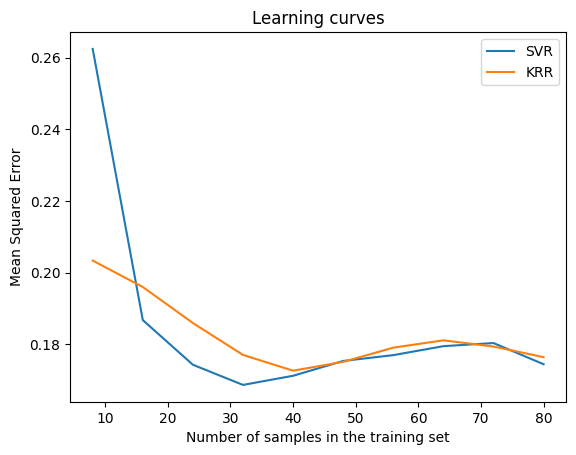

In [9]:
from sklearn.model_selection import LearningCurveDisplay

_, ax = plt.subplots()

svr = SVR(kernel="rbf", C=1e1, gamma=0.1)
kr = KernelRidge(kernel="rbf", alpha=0.1, gamma=0.1)

common_params = {
    "X": X[:100],
    "y": y[:100],
    "train_sizes": np.linspace(0.1, 1, 10),
    "scoring": "neg_mean_squared_error",
    "negate_score": True,
    "score_name": "Mean Squared Error",
    "score_type": "test",
    "std_display_style": None,
    "ax": ax,
}

LearningCurveDisplay.from_estimator(svr, **common_params)
LearningCurveDisplay.from_estimator(kr, **common_params)
ax.set_title("Learning curves")
ax.legend(handles=ax.get_legend_handles_labels()[0], labels=["SVR", "KRR"])

plt.show()